## Scenario 2 -  parallel execution of the quality check by operator alongside the robot's folding operation

Inorder to utilize the idle time of the operator , here the quality check process is initiated during the folding operation, allowing both tasks to be carried out concurrently.This modification mirrors a real-world scenario where the operator conducts quality checks while the robot is actively involved in folding the paper

In our case , the operator checks the quality of the previously folded paper while the robot is loading the paper . This will increase the number of folded papers and reduces operator idle time .

"Short summary of the result :
 The efficiency is increased by approximately 9 % .

The outcomes of the simulation are presented in a detailed table, offering insights into various performance metrics. Following the tabular representation, there are two accompanying bar charts. The first chart visually depicts the total count of folded papers and defective papers, providing a comparative view of these key production aspects. The second bar chart illustrates a comparison of average times associated with different processes.

In [72]:
import simpy
import random

#Defining Resources (Paper  ,Robot , Operator ,Paper Loading Station)

#defining Paper 

class Paper:
    def __init__(self, env, workstation1):
        self.is_defective = False
        pass

class PaperLoadingstation (object):
    # Initally the paper laodingstation has 100 papers.
    def __init__(self,env):
        self.papers = simpy.PaperLoadingstation (env, init=100, capaciy = 100)

    def check_availability_paperloadingstation(self,operator):
        # check if there is enough paper on the Loading station

        # This takes between 1-3 seconds
         yield self.env.timeout(random.randint(1, 3))

         if self.paperloadingstation == 1:
           # if there are enough paper, return True
           # print("there are enough paper available ")
           return True
         else:
            print("There are not enough paper available on the station , please refill ")
            
            return False
         
    def pick_paper(self,operator,workstation1,Robot):
        while not self.env.process(self.check_availability_paperloadingstation(Robot)):
         yield self.env.timeout(1)
         yield self.pickup_paperloadingstation.get(1) & self.env.process(self.restock())  # & self.env.process(workstation3.pickup_paper(robot))
    
    def restock_paperloadingstation(self):
         #restock the paperdispenser , this takes between 15-25 seconds
          yield self.env.timeout(random.randint(5,10))
          #restock the paper dispenser
          yield self.pickup_paperdispenser.put(100)
          print("The paper dispenser has been restocked")

#defining Robot
    
class Robot(object):
   
    def __init__(self,env,workstation1):
        self.env = env
        
        self.workstation1 = workstation1
        self.robot = simpy.Resource(env,capacity= 1)
        

    #The calibration takes place as a first step, this will takes around 2-3 Seconds
    def actuate(self,workstation1):
        yield self.env.timeout(random.randint(2,3))
        
    #the paper is loaded into the robot
    def load_paper(self,paper,paperloadingstation):
        yield self.env.timeout(random.randint(2,3))
        
     #the paper is loaded into Folding Base by the  robot , where the folding operation takes place
    def load_paper_to_foldingbase(self,paper):
        yield self.env.timeout(random.randint(2,3)) 
        
    
    #the Folding operation takes place by the robot
    def fold_paper(self,paper):
        yield self.env.timeout(random.randint(4,7))
        
    #the paper is unloaded from the Folding Base by the robot
    def unload_paper_from_foldingbase(self,paper):
        yield self.env.timeout(random.randint(2,3))
        
    def return_to_start(self):
        yield self.env.timeout(random.randint(2, 3))
    
    #At the end ,hand over the folded paper to the next station for further operations
    def hand_over_paper(self,workstation2):
        yield self.env.timeout (random.randint(2,3))
        

#defining Operator
        

class Operator (object):
    def __init__(self,env,workstation1,folded_papers):
        self.env = env
        self.workstation1 = workstation1
        self.folded_papers = folded_papers
        
        self.quality_check_times = {'check1': []}
        self.total_idle_time = 0
        
        
    def adjust_paper_loading(self, paper):
        # Check if the paper is loaded properly
        if random.random() < 0.32:  # 35% chance of loading error because of varying paper sizes
            print("Paper not loaded properly. Adjusting...")
            yield self.env.timeout(random.randint(1, 3))
            print("Adjustment completed.")
        else:
            print("Paper is loaded properly.")
        
        

    def quality_check_fold(self, paper):
        # Quality check after Folding Operation
        
        

        # Assume a 10% chance of a defect
        if random.random() < 0.1:
            paper.is_defective = True

        if paper.is_defective:
            # If the paper is defective, send it to waste
            print("Parallely the operator checks the quality of the Previously Folded Paper and that paper has a defect and goes to waste.")
            yield self.env.process(self.workstation1.WasteStation.dispose(paper))

            
        else:
            print("Parallely the operator checks the quality of the Previously Folded Paper and that Folded Paper passed quality check.")
        
        
        self.idle_start_time = self.env.now
        
    def align_paper(self, paper):
        # Check if the paper is aligned properly
        if random.random() < 0.32:  # 32% chance of misalignment , because of vaeing paper sizes
            print("Paper misaligned. Aligning...")
            yield self.env.timeout(random.randint(1, 3))
            print("Alignment completed.")
        else:
            print("Paper is aligned properly.")
    
        

#defining Workstation2 
class Workstation2(object):
    def __init__(self,env):
        self.env = env
        
class WasteStation(object):
    def __init__(self, env):
        self.env = env

    def dispose(self,paper):
        # Waste disposal process
        yield self.env.timeout(random.randint(2, 3))
        print("Paper has been disposed of as waste.")
         




In [73]:
##2.Environment
#In the 2nd step we will implement the environment in which the simulation takes place.
#Here we will set up the ressources and the genereal process flow.


In [74]:
#Defining the workstatiion1

class WorkStation1(object):
    def __init__(self,env,paper_list,robot,Workstation2,operator,folded_papers):
        self.env = env
        self.folded_papers = folded_papers
        
        self.operator = operator(env,self, self.folded_papers )
        self.idle_start_time = 0
        
        self.robot = robot(env,self)
        self.workstation2 = Workstation2(env)
        
        self.WasteStation = WasteStation(env) 
         
        self.folded_papers = 0
        self.total_operation_time = 0
        self.totalfolding1_time = 0
        self.paper_loading_verification_time = 0
        self.paper_alignment_verification_time = 0
        self.totalfolding2_time = 0
        self.total_quality_check_time = 0
        self.defective_papers = 0
        self.operator_idle_time = 0
        self.start_idle_time = 0
        self.total_idle_time = 0
        
        
        
        
        
        self.production_rate_data = []
        self.operation_times = []

    def workstation1_process(self,operator,paper,robot):
        
       #Track the time
        arrival_time=self.env.now
        yield self.env.process(self.robot.actuate(self))
        print ("Operator started the process at "+str(self.env.now)+"seconds.")

        #The paper is loaded into the robot
        yield self.env.process(self.robot.load_paper(paper,PaperLoadingstation))
        print("The Paper " +str(self.folded_papers)+" has been loaded into the robot at "+str(self.env.now)+" seconds.")
         #Quality check of the previous  by the operator during the paper loading process
        yield self.env.process(self.operator.quality_check_fold(paper))
        if paper.is_defective:
            self.defective_papers += 1
        
        
        

        #the error is checked by the operator
        paper_loading_verification_start_time = self.env.now
        yield self.env.process(self.operator.adjust_paper_loading(paper))
        print("The Paper " +str(self.folded_papers)+" has been checked for loading errors at "+str(self.env.now)+" seconds.")
        paper_loading_verification_end_time = self.env.now - paper_loading_verification_start_time
       
        

        #The paper is loaded into the Folding Base by the robot
        operator.idle2_start_time = self.env.now
        yield self.env.process(self.robot.load_paper_to_foldingbase(paper))
        print ("The paper " +str(self.folded_papers)+" has been loaded into the Folding Base at "+str(self.env.now)+" seconds.")
        operator.idle2_end_time = self.env.now - operator.idle2_start_time

        #the paper alignment is checked by the operator
        paper_alignment_verification_start_time = self.env.now
        print ("The paper " +str(self.folded_papers)+" has been checked for alignment at "+str(self.env.now)+" seconds.")
        yield self.env.process(self.operator.align_paper(paper))
               
        paper_alignment_verification_end_time = self.env.now - paper_alignment_verification_start_time
                
        #The Folding operation takes place by the robot , some steps are done by the operator
        folding1_start_time = self.env.now
        yield self.env.process(self.robot.fold_paper(paper))
        folding1_end_time = self.env.now - folding1_start_time
        print ("The paper " +str(self.folded_papers)+" has been folded at "+str(self.env.now)+" seconds.")

        #The paper is unloaded from the Folding Base by the robot
        operator.idle3_start_time = self.env.now
        yield self.env.process(self.robot.unload_paper_from_foldingbase(paper))
        print ("The paper " +str(self.folded_papers)+" has been unloaded from the Folding Base at "+str(self.env.now)+" seconds.")
        
       

        #the paper is handed over to the next station for further operations
        yield self.env.process(self.robot.hand_over_paper(Workstation2))
        print ("The paper "+str(self.folded_papers)+" has been placed at the collection area at "+str(self.env.now)+" seconds.")
        operator.idle3_end_time = self.env.now - operator.idle3_start_time

        
        #the robot returns to the start position
        operator.idle4_start_time = self.env.now
        yield self.env.process(self.robot.return_to_start())
        print ("The robot has returned to the start position at "+str(self.env.now)+"seconds.")
        operator.idle4_end_time = self.env.now - operator.idle4_start_time
        #the operator is idle during the paper loading process, and the time is recorded

        #Operation time
        operation_time = self.env.now - arrival_time
        #Total folding time
        totalfolding1_time = folding1_end_time 
        #operator idle time
        operator_idle_time = operator.idle2_end_time + operator.idle3_end_time + operator.idle4_end_time
        # add the operator idle time to the list of operator idle times
        self.operator_idle_time += operator_idle_time     
                
        # add the paper loading verification time to the list of paper loading verification times
        self.paper_loading_verification_time += paper_loading_verification_end_time
        # add the paper alignment verification time to the list of paper alignment verification times
        self.paper_alignment_verification_time += paper_alignment_verification_end_time
        
        

        # add the production rate data to the list
        self.production_rate_data.append((self.env.now, self.folded_papers))

        
        # add the folding time to the list of folding times
        self.totalfolding1_time += totalfolding1_time
        
        
    
        # add the process time to the total production time
        self.total_operation_time += operation_time

        # count the produced papers
        self.folded_papers += 1  
        


In [75]:
###3.Simulation
#In the third step we will run the simulation and therefor define an initial set of parameter to simulate.


In [76]:
def paper_generator(env, workstation1, paper_list):
    while True:
        interarrival_time = random.randint(2,5)

        paper = Paper(env, workstation1)
        paper_list.append(paper)

        operator = Operator(env, workstation1, workstation1.folded_papers)
        robot = Robot(env, workstation1)

        yield env.process(workstation1.workstation1_process(operator, paper,robot))

        yield env.timeout(interarrival_time)
        print("Next Paper " + str(workstation1.folded_papers) + " arrived at Station 1 at " + str(env.now) + " seconds.")
import simpy
env = simpy.Environment()

paper_list=[]
folded_papers=0
operator = Operator(env,WorkStation1,folded_papers)

workstation1=WorkStation1(env,paper_list,Robot,Workstation2,Operator,folded_papers)


print ("The number of produced papers is "+str(workstation1.folded_papers-1)+".")
print ("the simulation duration is "+str(env.now)+"seconds.")
env.process(paper_generator(env,workstation1,paper_list))
env.run(until=28800)



The number of produced papers is -1.
the simulation duration is 0seconds.
Operator started the process at 2seconds.
The Paper 0 has been loaded into the robot at 4 seconds.
Parallely the operator checks the quality of the Previously Folded Paper and that Folded Paper passed quality check.
Paper is loaded properly.
The Paper 0 has been checked for loading errors at 4 seconds.
The paper 0 has been loaded into the Folding Base at 7 seconds.
The paper 0 has been checked for alignment at 7 seconds.
Paper misaligned. Aligning...
Alignment completed.
The paper 0 has been folded at 15 seconds.
The paper 0 has been unloaded from the Folding Base at 17 seconds.
The paper 0 has been placed at the collection area at 20 seconds.
The robot has returned to the start position at 22seconds.
Next Paper 1 arrived at Station 1 at 26 seconds.
Operator started the process at 28seconds.
The Paper 1 has been loaded into the robot at 31 seconds.
Parallely the operator checks the quality of the Previously Folde

## Results of the Simulation
The outcomes of the simulation are presented in a detailed table, offering insights into various performance metrics. Following the tabular representation, there are two accompanying bar charts. The first chart visually depicts the total count of folded papers and defective papers, providing a comparative view of these key production aspects. The second bar chart illustrates a comparison of average times associated with different processes.

The Simulation is ended and the results are shown below
The number of produced papers is 1131.
the simulation duration is 28800seconds.
The number of produced papers is 1131.
The average process time of the produced papers is 25.42 seconds.
The average Folding process time is 5.49 seconds.
The average Quality check time is 0.00 seconds.
The average paper loading verification time is 0.61 seconds.
The average paper alignment verification time is 0.61 seconds.
The number of defective papers is 137.
The average operator idle time is 9.95 seconds.
+-----------------------------------------------+---------------+
| Metric                                        | Value         |
+===============================================+===============+
| Produced Papers                               | 1131          |
+-----------------------------------------------+---------------+
| Simulation Duration                           | 28800 seconds |
+-----------------------------------------------+-----

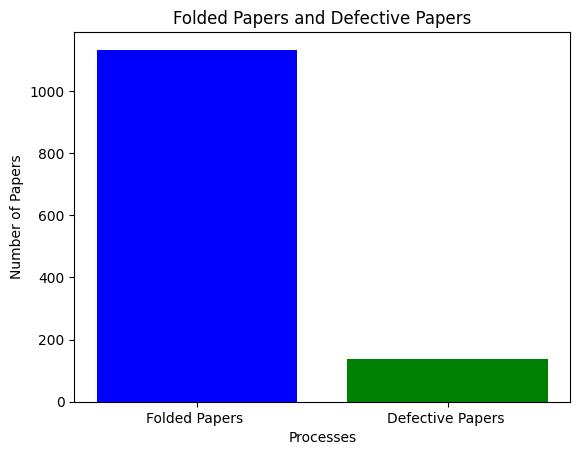

In [77]:
print ("The Simulation is ended and the results are shown below")
print ("The number of produced papers is "+str(workstation1.folded_papers-1)+".")
print ("the simulation duration is "+str(env.now)+"seconds.")
print ("The number of produced papers is "+str(workstation1.folded_papers-1)+".")
# Calculate the average folding time

produced_papers = len(paper_list)
simulation_time = 28800
average_process_time = simulation_time/produced_papers
average_folding1_time = workstation1.totalfolding1_time/produced_papers
average_folding2_time = workstation1.totalfolding2_time/produced_papers
average_folding_time = average_folding1_time + average_folding2_time
average_paper_loading_verification_time = workstation1.paper_loading_verification_time/produced_papers
average_paper_alignment_verification_time = workstation1.paper_alignment_verification_time/produced_papers
average_quality_check_time = workstation1.total_quality_check_time/produced_papers
average_operator_idle_time = workstation1.operator_idle_time/produced_papers

print ("The average process time of the produced papers is {:.2f} seconds.".format(average_process_time))
# After running the simulation, calculate and print the average folding 1 time
print ("The average Folding process time is {:.2f} seconds.".format(average_folding1_time))
print ("The average Quality check time is {:.2f} seconds.".format(average_quality_check_time))
print ("The average paper loading verification time is {:.2f} seconds.".format(average_paper_loading_verification_time))
print ("The average paper alignment verification time is {:.2f} seconds.".format(average_paper_alignment_verification_time))
print ("The number of defective papers is "+str(workstation1.defective_papers)+".")
print ("The average operator idle time is {:.2f} seconds.".format(average_operator_idle_time))

#The presented table provides a comprehensive summary of key performance metrics and 
# outcomes from a simulated production process. It includes essential information such as the total number of produced papers, the overall simulation duration, and various average times associated with different stages of the production workflow. 

from tabulate import tabulate

table_data = [
    ("Produced Papers", workstation1.folded_papers-1),
    ("Simulation Duration", f"{env.now} seconds"),
    ("Average Process Time (Cycle Time)", "{:.2f} seconds".format(average_process_time)),
    ("Average Folding  Time", "{:.2f} seconds".format(average_folding1_time)),
    ("Average Paper Loading Verification Time", "{:.2f} seconds".format(average_paper_loading_verification_time)),
    ("Average Paper Alignment Verification Time", "{:.2f} seconds".format(average_paper_alignment_verification_time)),
    ("Average Quality Check Time", "{:.2f} seconds".format(average_quality_check_time)),
    ("Defective Papers", workstation1.defective_papers),
    ("Average Operator Idle Time during the process", "{:.2f} seconds".format(average_operator_idle_time)
    ),
]


# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt="grid"))

# bar chart , Categories and corresponding average times
categories = ['Folded Papers ', 'Defective Papers ']
average_times = [produced_papers, workstation1.defective_papers]

import matplotlib.pyplot as plt
import numpy as np
# Plotting the bar chart
plt.bar(categories, average_times, color=['blue', 'green'])
plt.xlabel('Processes')
plt.ylabel('Number of Papers')
plt.title('Folded Papers and Defective Papers')
plt.show()




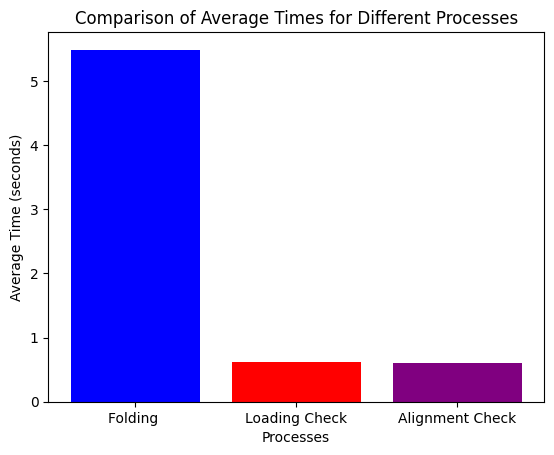

In [78]:
#This Bar chart that visually compares the average times for different processes.

import matplotlib.pyplot as plt
import numpy as np



# Categories and corresponding average times
categories = ['Folding ','Loading Check', 'Alignment Check']
average_times = [average_folding1_time, average_paper_loading_verification_time, average_paper_alignment_verification_time]

# Plotting the bar chart
plt.bar(categories, average_times, color=['blue', 'red', 'purple'])
plt.xlabel('Processes')
plt.ylabel('Average Time (seconds)')
plt.title('Comparison of Average Times for Different Processes')
plt.show()

